<a href="https://colab.research.google.com/github/tjann/api-python/blob/internnotebooks/notebooks/Place_Similarity_with_Data_Commons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2020 Google LLC.
SPDX-License-Identifier: Apache-2.0

Author: Jin Peng Zhou

# Using Data Commons statistical variables to compute place similarity and dissimilarity
Welcome to this Colab notebook! We will walk you through several examples of exploring similar and dissimilar places based on [`StatisticalVariable`](https://docs.datacommons.org/statistical_variables.html) values available in Data Commons. There are primarily two types of data we define here:
1. Snapshot. We look at the statistical variable value at a given time (most likely the latest observation). The similarity criterion we used is absolute difference between two values.
2. Time series. We look at all available statistical variable values as a time series. The similarity criterion can be either Pearson correlation (pearson), or Mean Square Error (mse).

We hope the examples can help you better understand how to use Data Commons for further research and analysis, and in particular, identifying similar places based on your set of criteria.

## Load Packages

In [1]:
!pip install datacommons --quiet
!pip install -U plotly --quiet
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import rankdata, pearsonr
import datacommons as dc
import numpy as np
import copy
import pandas as pd
from urllib.request import urlopen
import json
import plotly.express as px


## Define our inputs
1. query_dcid: this is the place we are looking at.
2. K: number of similar/dissimilar places to retrieve.
3. places: a list of candidate places to compare. Each element is a place dcid

In [2]:
query_dcid = 'geoId/0666000'  # San Diego city
# query_dcid = 'geoId/06085' # Santa Clara county
K = 10

## Prepare places input
Here we need to first get all the places we are interested in. This could be counties in US, CDC500 cities, CDC500 cities in a particular state, etc. The format we need is a list of dcids. We included some examples below

In [3]:
places = dc.get_property_values(["CDC500_City"], "member", limit=500)["CDC500_City"]  # CDC 500 cities
# places = dc.get_places_in(['country/USA'], "County")['country/USA']  # all counties in US
# places = dc.get_places_in(['geoId/06'], "County")['geoId/06']  # all counties in California

Generate a dictionary of place and its name

In [4]:
places = sorted(places)
place_dict = dc.get_property_values(places, "name")

Get all the state and place information we need

In [5]:
all_states = dc.get_places_in(['country/USA'], "State")['country/USA']
all_states = dc.get_property_values(all_states, "name")
# all_counties = dc.get_places_in([place_domain], "County")[place_domain]
# all_counties = dc.get_property_values(all_counties, "name")
# id_list = sorted(list(all_counties.keys()))

## Single statistical variable snapshot case
First, let's look at one statistical variable say unemployment rate for snapshot case. For this statistical variable, it does not make sense to look at it on a per capita basis, so we set it to False

In [6]:
statvars = ['UnemploymentRate_Person']
per_capita = [False]
time_series = [False]
time_series_similarity_types = ['pearson']  # either pearson or mse for time series similarity metric
statvar_display_names = ['Unemployment Rate']

## Get all the raw data we need

In [7]:
def convert_dicts(get_stat_all_dict, statvars):
    data = []
    for i in range(len(statvars)):
        current_statvar_data_dict = {}
        for geo, statvar_dict in get_stat_all_dict.items():
            if 'sourceSeries' not in statvar_dict[statvars[i]]:
                current_statvar_data_dict[geo] = None
            else:
                length_list = []
                for source in statvar_dict[statvars[i]]['sourceSeries']:
                    length_list.append(len(source['val']))
                longest_index = length_list.index(max(length_list))
                current_statvar_dict = statvar_dict[statvars[i]]['sourceSeries'][longest_index]['val']  # use the longest series by default
                current_statvar_data_dict[geo] = {'data': current_statvar_dict}
        data.append(current_statvar_data_dict)
    return data

def get_data_and_population(places, statvars):
    get_stat_all_dict = dc.get_stat_all(places, statvars)
    data = convert_dicts(get_stat_all_dict, statvars)
    get_stat_all_population = dc.get_stat_all(places, ['Count_Person'])
    population = convert_dicts(get_stat_all_population, ['Count_Person'])[0]
    return data, population

In [8]:
data, population = get_data_and_population(places, statvars)

## Normalize the data if applicable and compute distance
Here we will first normalize the data if per_capita is True
We then for each statistical variable, compute distance between query place and every other place. The smaller the distance is, the more similar two places are based on this statistical variable. 

In [9]:
def normalize_single(data_dict, population_dict, quiet=False):
    new_data_dict = {}
    population_years = sorted(list(population_dict.keys()))
    for k in data_dict.keys():
        if k[:4] in population_years:
            new_data_dict[k] = data_dict[k] / population_dict[k[:4]]
        elif int(k[:4]) > int(population_years[-1]):
            new_data_dict[k] = data_dict[k] / population_dict[population_years[-1]]
            if not quiet:
                print('observation on {0} is leading population, using latest population value on {1}'.format(k, population_years[-1]))
        else:
            if not quiet:
               print('dropping {0} data due to no matching denominator'.format(k))
    if not quiet:
        print(100 * len(new_data_dict) / len(data_dict), 'percent of data successfully normalized and not dropped.')
    return new_data_dict

def normalize_data(data, population, per_capita, quiet=False):
    data = copy.deepcopy(data)
    # if cannot normalize all values for a place, drop this place
    assert len(data) == len(per_capita)
    for i in range(len(per_capita)):
        if per_capita[i]:
            if not quiet:
                print('normalizing statvar {0}'.format(i))
            current_data = data[i]
            for k in current_data.keys():
                if not quiet:
                    print('normalizing {0}'.format(k))
                if current_data[k] is not None and population[k] is not None:
                    current_data_place = current_data[k]['data']
                    population_place = population[k]['data']
                    data[i][k]['data'] = normalize_single(current_data_place, population_place, quiet)
                else:
                    if not quiet:
                        print('dropping {0} due to no data'.format(k))
    return data

In [10]:
def compute_distances(query_dcid, data, statvars, time_series, time_series_similarity_types, quiet=False):
    distance_lists = []
    for i in range(len(data)):
        if not quiet:
            print('processing {0} data'.format(statvars[i]))
        distance_lists.append(get_distance_all(data[i], query_dcid, time_series[i], time_series_similarity_types[i], quiet))
    return distance_lists

def get_distance_all(data_dict, query, time_series, time_series_similarity_type, quiet=False):
    id_list = []
    distance_list = []
    if 'data' not in data_dict[query]:
        if not quiet:
            print('WARNING: no observation available for {0}'.format(query))
        return {}
    query_dict = data_dict[query]['data']
    for k in data_dict.keys():
        id_list.append(k)
        # if 'data' in data_dict[k].keys():  # Before API change
        if data_dict[k] is not None and 'data' in data_dict[k].keys():
            distance_list.append(get_distance_pair(query_dict, data_dict[k]['data'], time_series, time_series_similarity_type, quiet))
            if distance_list[-1] == float('inf') and not quiet:
                print(
                    'WARNING: distance between {0} and {1} is infinity due to no common observation dates'.format(query,
                                                                                                                  k))
        else:
            distance_list.append(get_distance_pair(query_dict, {}, time_series, time_series_similarity_type, quiet))
            if distance_list[-1] == float('inf') and not quiet:
                print(
                    'WARNING: distance between {0} and {1} is infinity due to no observation for {1}'.format(query, k))

    id_list, distance_list = (list(t) for t in zip(*sorted(zip(id_list, distance_list))))
    if not quiet:
        print('max non-infinite distance:', np.array(distance_list)[np.array(distance_list) != float('inf')].max())
        print('min distance:', np.array(distance_list)[np.array(distance_list) != float('inf')].min())
    return distance_list

def get_distance_pair(dict_a, dict_b, time_series, time_series_similarity_type, quiet=False):
    common_dates = get_common_keys(dict_a, dict_b)
    if len(common_dates) == 0:
        if not quiet:
            print('WARNING: no common dates between two time series, will return inf')
        return float('inf')
    common_series_a = [dict_a[date] for date in common_dates]
    common_series_b = [dict_b[date] for date in common_dates]
    if time_series:
        if time_series_similarity_type == 'pearson':
            if len(common_series_a) < 2:
                return float('inf')  # due to insufficient number of data points
            else:
                r, p = pearsonr(common_series_a, common_series_b)  # need to convert correlation to some distance measure
                return 1 - r
        elif time_series_similarity_type == 'mse':
            return np.square(np.subtract(common_series_a, common_series_b)).mean()
        else:
            raise NotImplementedError
    else:
        return abs(common_series_a[-1] - common_series_b[-1])

def get_common_keys(dict_a, dict_b):
    return sorted(list(set(dict_a.keys()).intersection(set(dict_b.keys()))))

def convert_dict_to_list(d):
    sorted_dict = sorted(d.items())  # sorted by key, return a list of tuples
    x, y = zip(*sorted_dict)  # unpack a list of pairs into two tuples
    return x, y

In [11]:
normalized_data = normalize_data(data, population, per_capita)
distance_lists = compute_distances(query_dcid, data, statvars, time_series, time_series_similarity_types)

processing UnemploymentRate_Person data
max non-infinite distance: 13.3
min distance: 0.0


## Retrieving similar counties
We rank each place using the distance computed by our similarity metric and the rank is aggregated for each place.
First we will retrieve counties that are similar to Santa Clara.
This is achieved by setting similar to True

In [12]:
def rank_all_remove_inf(places, distance_lists, similar=True):
    distances = np.array(distance_lists)
    inf_indices = list(set(np.where(distances == float('inf'))[1]))
    new_places = np.delete(places, inf_indices)
    new_distances = np.delete(distances, inf_indices, axis=1)
    assert len(new_places) == new_distances.shape[1]
    ranks = np.zeros((new_distances.shape[1]))
    for i in range(new_distances.shape[0]):
        ranks = ranks + rankdata(new_distances[i, :], method='min')
    if not similar:
        topK = np.argsort(-ranks)
    else:
        topK = np.argsort(ranks)
    return new_places[topK]

In [13]:
all_dcid_ranked = rank_all_remove_inf(places, distance_lists, similar=True)
# delete query dcid and add back to the front approriately due to tie conditions
all_dcid_ranked = all_dcid_ranked[all_dcid_ranked != query_dcid]
all_dcid_ranked = np.insert(all_dcid_ranked, 0, query_dcid)

## Visualize our results
For time series data, we show the retrieval counties by plotting them pairwise per graph.
For snapshot data, we show the retrieval counties in a table
Let's Define some plotting functions

In [14]:
def multiple_plot(x_list, y_list, x_label, y_label, legends):
    assert len(x_list) == len(y_list)
    assert len(x_list) == len(legends)
    for i in range(len(x_list)):
        x = x_list[i]
        y = y_list[i]
        x = matplotlib.dates.datestr2num(x)
        plt.plot_date(x, y, label=legends[i])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc="best")
    plt.show()
def visualize_all(normalized_data, query_dcid, all_dcid_ranked, place_dict, statvar_display_names, k, time_series, all_states):
    snapshot_indices = []
    for i in range(len(time_series)):
        if not time_series[i]:
            snapshot_indices.append(i)
    df = visualize_snapshots(normalized_data, query_dcid, all_dcid_ranked, place_dict, statvar_display_names, snapshot_indices, all_states)
    for i in range(len(time_series)):
        if time_series[i]:
            print('===================================Plotting {0} time series==================================='.format(statvar_display_names[i]))
            visualize_time_series_single(normalized_data[i], query_dcid, all_dcid_ranked, place_dict, statvar_display_names[i], k)
    return df


def visualize_time_series_single(current_data, query_dcid, all_dcid_ranked, place_dict, statvar_display_name, k):
    query_x, query_y = convert_dict_to_list(current_data[query_dcid]['data'])
    for j in range(k):
        current_x, current_y = convert_dict_to_list(current_data[all_dcid_ranked[j + 1]]['data'])
        multiple_plot([query_x, current_x], [query_y, current_y], 'time', statvar_display_name, [place_dict[query_dcid][0], place_dict[all_dcid_ranked[j + 1]][0]])


def visualize_snapshots(normalized_data, query_dcid, all_dcid_ranked, place_dict, statvar_display_names, snapshot_indices, all_states):
    results = []
    query_series_list = []
    for index in snapshot_indices:
        query_series_list.append(normalized_data[index][query_dcid]['data'])
    for i in range(len(all_dcid_ranked)):
        dcid = all_dcid_ranked[i]
        current = [dcid, place_dict[dcid][0], all_states[dcid[:8]][0]]
        for j in range(len(snapshot_indices)):
            current_series = normalized_data[snapshot_indices[j]][dcid]['data']
            date = get_common_keys(query_series_list[j], current_series)[-1]
            value = current_series[date]
            current.extend([value, date])
        results.append(current)
    columns = ['dcid', 'name', 'state']
    for i in range(len(snapshot_indices)):
        columns.extend([statvar_display_names[snapshot_indices[i]], statvar_display_names[snapshot_indices[i]] + '_date'])
    df = pd.DataFrame(results, columns=columns)
    return df

In [15]:
df = visualize_all(normalized_data, query_dcid, all_dcid_ranked, place_dict, statvar_display_names, K, time_series, all_states)
df.head(K + 1)

dcid          name  ... Unemployment Rate  Unemployment Rate_date
0   geoId/0666000     San Diego  ...               9.7                 2020-08
1   geoId/0107000    Birmingham  ...               9.7                 2020-08
2   geoId/4810768   Brownsville  ...               9.7                 2020-08
3   geoId/0680812       Turlock  ...               9.7                 2020-08
4   geoId/1912000  Cedar Rapids  ...               9.7                 2020-08
5   geoId/2706616   Bloomington  ...               9.7                 2020-08
6   geoId/4715160   Clarksville  ...               9.7                 2020-08
7   geoId/0664224       Salinas  ...               9.7                 2020-08
8   geoId/1831000       Hammond  ...               9.7                 2020-08
9   geoId/4159000      Portland  ...               9.7                 2020-08
10  geoId/0952000     New Haven  ...               9.7                 2020-08

[11 rows x 5 columns]

## Now let's retrieve dissimilar counties

In [16]:
similar = False # True for retrieving least similar entities
all_dcid_ranked = rank_all_remove_inf(places, distance_lists, similar)
# delete query dcid and add back to the front approriately due to tie conditions
all_dcid_ranked = all_dcid_ranked[all_dcid_ranked != query_dcid]
all_dcid_ranked = np.insert(all_dcid_ranked, 0, query_dcid)

In [17]:
df = visualize_all(normalized_data, query_dcid, all_dcid_ranked, place_dict, statvar_display_names, K, time_series, all_states)
df.head(K + 1)

dcid         name  ... Unemployment Rate  Unemployment Rate_date
0   geoId/0666000    San Diego  ...               9.7                 2020-08
1   geoId/2534550     Lawrence  ...              23.0                 2020-08
2   geoId/0636546    Inglewood  ...              21.7                 2020-08
3   geoId/2622000      Detroit  ...              21.0                 2020-08
4   geoId/0615044      Compton  ...              20.8                 2020-08
5   geoId/3457000     Paterson  ...              20.7                 2020-08
6   geoId/0632548    Hawthorne  ...              19.8                 2020-08
7   geoId/0604982   Bellflower  ...              18.7                 2020-08
8   geoId/2567000  Springfield  ...              18.6                 2020-08
9   geoId/0655156     Palmdale  ...              18.6                 2020-08
10  geoId/0644574      Lynwood  ...              18.5                 2020-08

[11 rows x 5 columns]

## Encapsulate the above functions to one single function
After we understand the functionality of each function, let's define one function that gets the data, normalize it, compute distance and display results

In [18]:
def retrieve_compute_visualize(query_dcid, places, statvars, statvar_display_names, per_capita, time_series, time_series_similarity_types, similar, k, quiet=False):
    all_states = dc.get_places_in(['country/USA'], "State")['country/USA']
    all_states = dc.get_property_values(all_states, "name")
    places = sorted(places)
    place_dict = dc.get_property_values(places, "name")
    data, population = get_data_and_population(places, statvars)
    normalized_data = normalize_data(data, population, per_capita, quiet)
    distance_lists = compute_distances(query_dcid, data, statvars, time_series, time_series_similarity_types, quiet)
    all_dcid_ranked = rank_all_remove_inf(places, distance_lists, similar)
    all_dcid_ranked = all_dcid_ranked[all_dcid_ranked != query_dcid]
    all_dcid_ranked = np.insert(all_dcid_ranked, 0, query_dcid)
    df = visualize_all(normalized_data, query_dcid, all_dcid_ranked, place_dict, statvar_display_names, k, time_series, all_states)
    return df

## Single statistical variable time series case
We again look at Santa Clara county but this time focus on median income in time series. We choose Pearson correlation to measure similarity and once again, restrict ourselves to California state only

In [19]:
query_dcid = 'geoId/06085' # Santa Clara county
K = 10
statvars = ['Median_Income_Person']
per_capita = [False]
time_series = [True]
time_series_similarity_types = ['pearson']
statvar_display_names = ['Median Income']
similar = True
places = dc.get_places_in(['geoId/06'], "County")['geoId/06']

We observe indeed the median income time series plots show similar trend on median income even though their difference is consistently large in some cases. This is expected since we used Pearson correlation coefficient, which unlike MSE, is looking at trend rather than absolute value differences.

processing Median_Income_Person data
max non-infinite distance: 1.3087396586209936
min distance: 0.0
===================================Plotting Median Income time series===================================


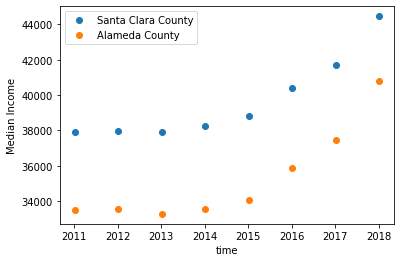

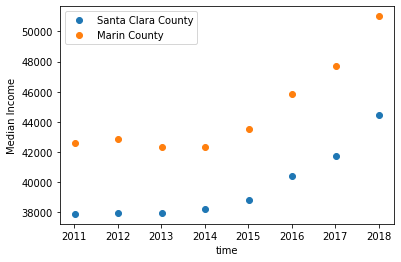

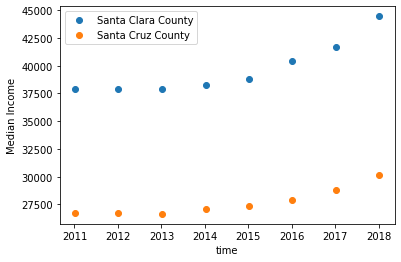

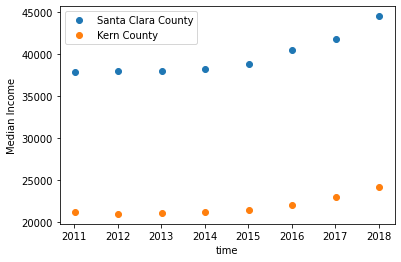

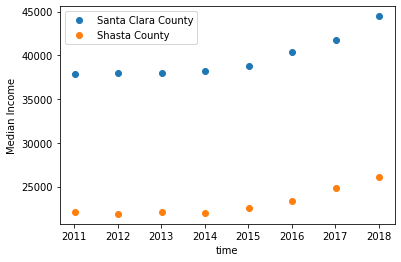

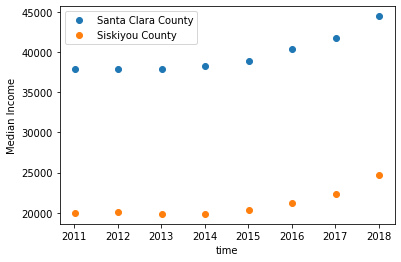

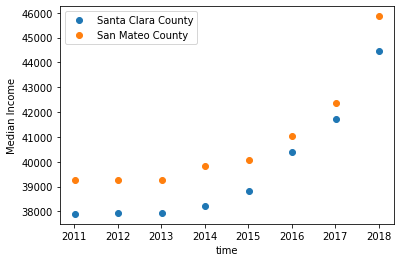

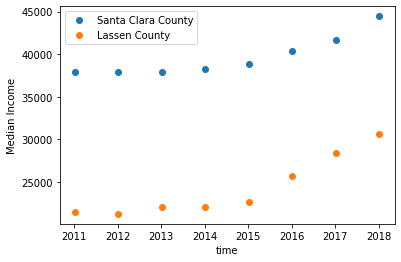

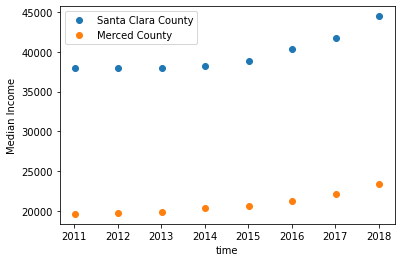

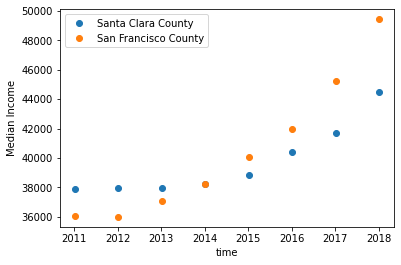

dcid                  name       state
0   geoId/06085    Santa Clara County  California
1   geoId/06001        Alameda County  California
2   geoId/06041          Marin County  California
3   geoId/06087     Santa Cruz County  California
4   geoId/06029           Kern County  California
5   geoId/06089         Shasta County  California
6   geoId/06093       Siskiyou County  California
7   geoId/06081      San Mateo County  California
8   geoId/06035         Lassen County  California
9   geoId/06047         Merced County  California
10  geoId/06075  San Francisco County  California

In [20]:
df = retrieve_compute_visualize(query_dcid, places, statvars, statvar_display_names, per_capita, time_series, time_series_similarity_types, similar, K)
df.head(K + 1)

## Change it to mse and rerun everything
Now every corresponding observations are much more closer

processing Median_Income_Person data
max non-infinite distance: 528404967.875
min distance: 0.0
===================================Plotting Median Income time series===================================


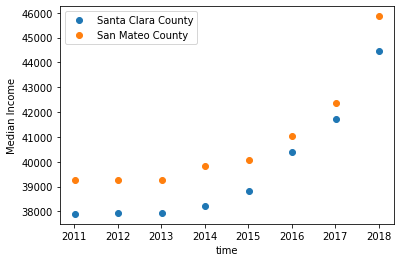

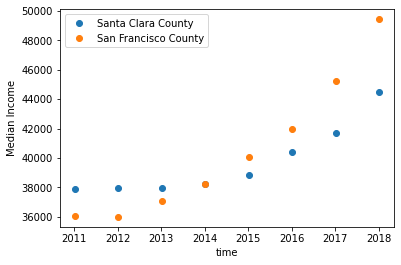

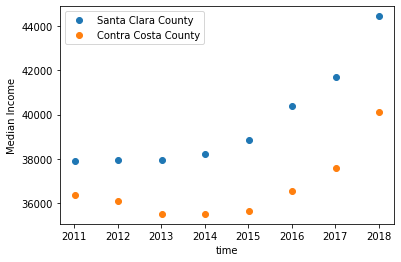

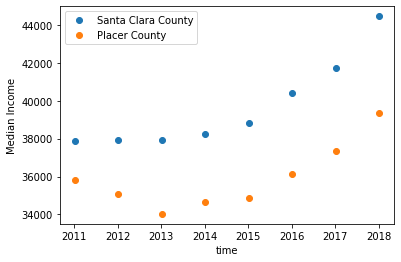

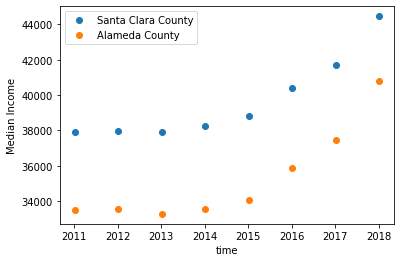

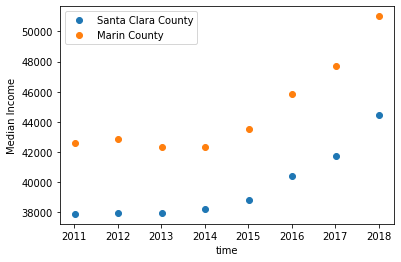

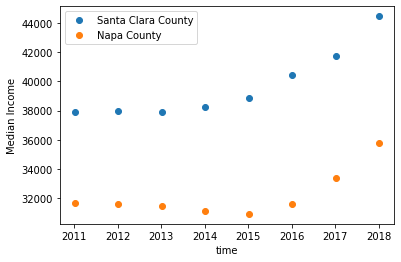

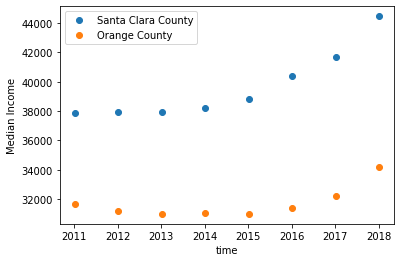

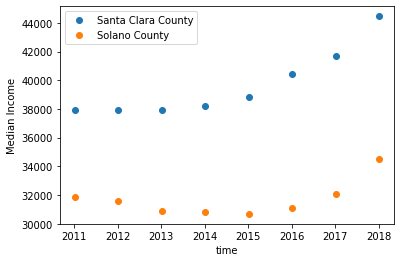

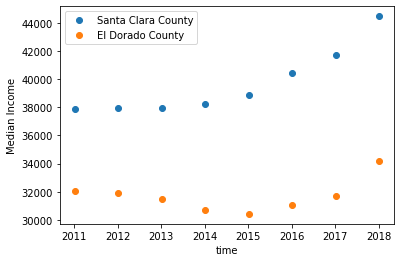

dcid                  name       state
0   geoId/06085    Santa Clara County  California
1   geoId/06081      San Mateo County  California
2   geoId/06075  San Francisco County  California
3   geoId/06013   Contra Costa County  California
4   geoId/06061         Placer County  California
5   geoId/06001        Alameda County  California
6   geoId/06041          Marin County  California
7   geoId/06055           Napa County  California
8   geoId/06059         Orange County  California
9   geoId/06095         Solano County  California
10  geoId/06017      El Dorado County  California

In [21]:
time_series_similarity_types = ['mse']
df = retrieve_compute_visualize(query_dcid, places, statvars, statvar_display_names, per_capita, time_series, time_series_similarity_types, similar, K)
df.head(K + 1)

## We can even look at both metrics at the same time
In this case, for each metric, the algorithm considers it indepedently and assign ranks to every places based on the comuputed similarity. The rank is then aggregated to produce the final retrieval results.

You will see two identical sets of figures. This is due to the fact that our algorithm actually treats the two metrics as two different statistical variables, and it will plot for the retrieval results for each statistical variables indepdently. This is helpful when we are looking at multiple statistical variables. 

processing Median_Income_Person data
max non-infinite distance: 528404967.875
min distance: 0.0
processing Median_Income_Person data
max non-infinite distance: 1.3087396586209936
min distance: 0.0
===================================Plotting Median Income Pearson time series===================================


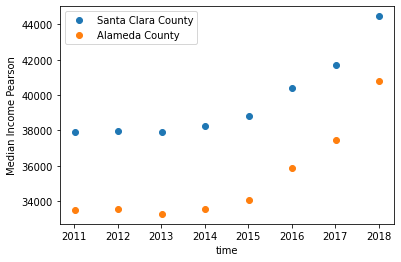

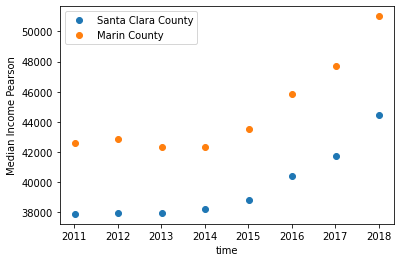

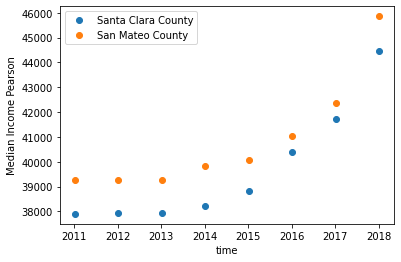

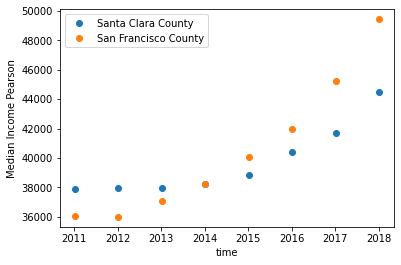

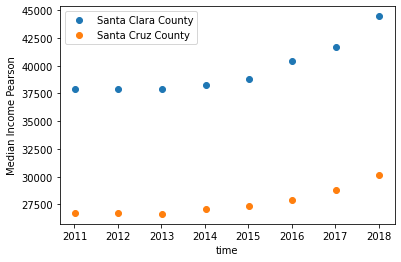

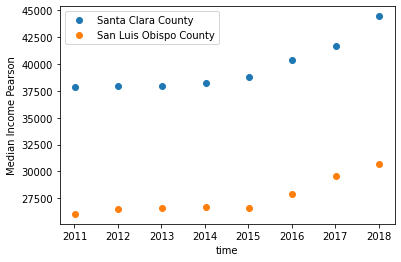

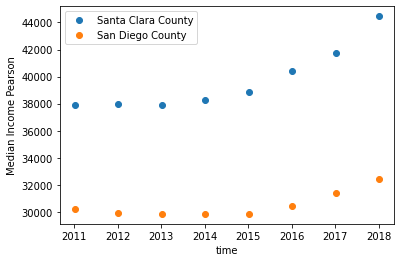

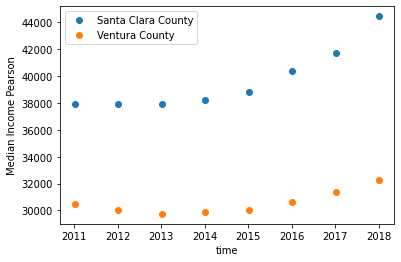

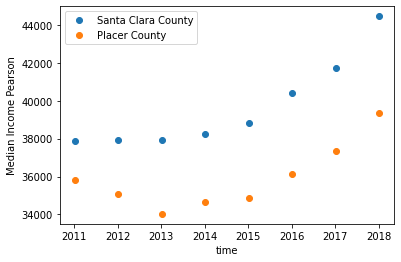

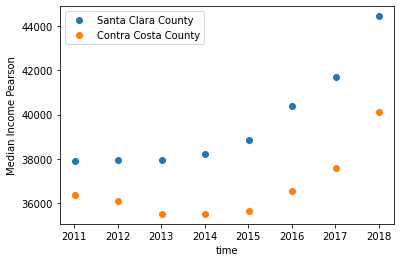

===================================Plotting Median Income MSE time series===================================


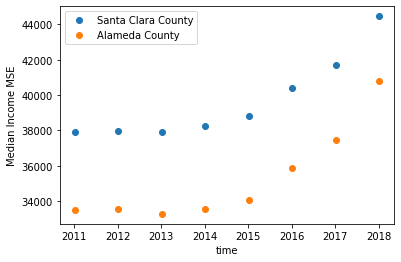

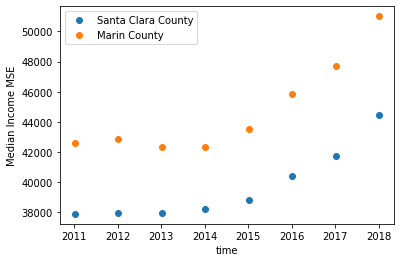

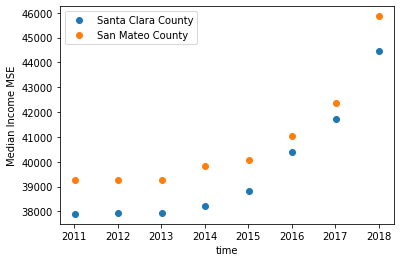

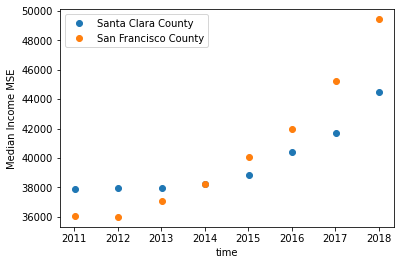

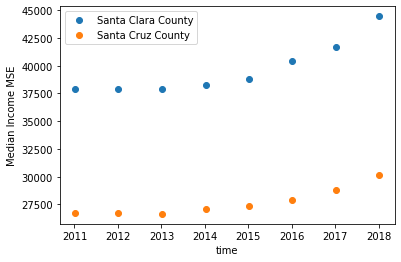

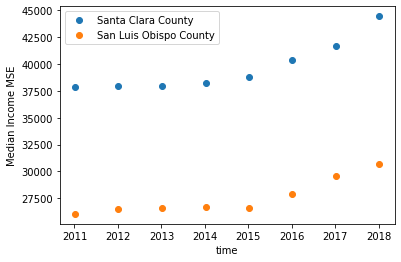

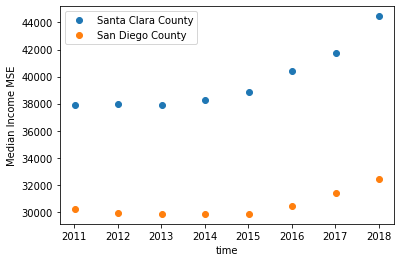

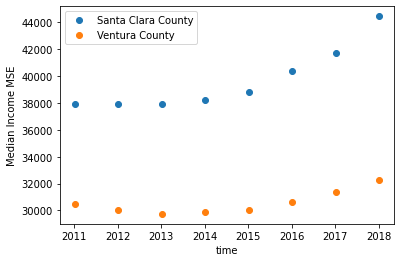

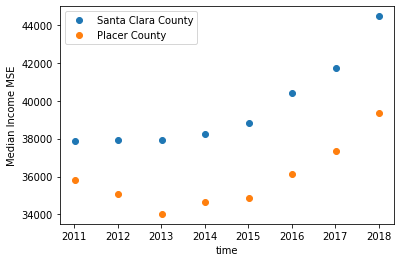

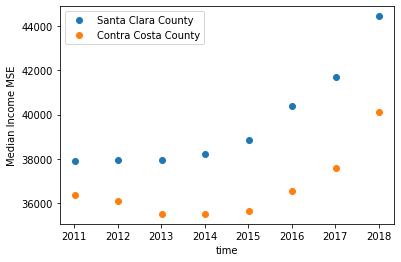

dcid                    name       state
0   geoId/06085      Santa Clara County  California
1   geoId/06001          Alameda County  California
2   geoId/06041            Marin County  California
3   geoId/06081        San Mateo County  California
4   geoId/06075    San Francisco County  California
5   geoId/06087       Santa Cruz County  California
6   geoId/06079  San Luis Obispo County  California
7   geoId/06073        San Diego County  California
8   geoId/06111          Ventura County  California
9   geoId/06061           Placer County  California
10  geoId/06013     Contra Costa County  California

In [22]:
statvars = ['Median_Income_Person', 'Median_Income_Person']
per_capita = [False, False]
time_series = [True, True]
time_series_similarity_types = ['mse', 'pearson']
statvar_display_names = ['Median Income Pearson', 'Median Income MSE']
df = retrieve_compute_visualize(query_dcid, places, statvars, statvar_display_names, per_capita, time_series, time_series_similarity_types, similar, K)
df.head(K + 1)

## Now we can look at multiple statistical variables at the same time!
We look at three statistical variables: unemployment rate, median income, labour force participation rate. Since Data Commons does not have per capita statistics for labour force, we set per capita to True for that variable. We look at the first two statistical variables with time series based on Pearson correlation and labour force participation rate as snapshot. The plots for unemployment rate and median income show very similar trend between Santa Clara county and retrieved places. The labour force participation rate is very close between query county and retrieved counties as well.
This time, we will look at all counties in US, not just California. So it may take a while to get the data.

===================================Plotting Unemployment Rate time series===================================


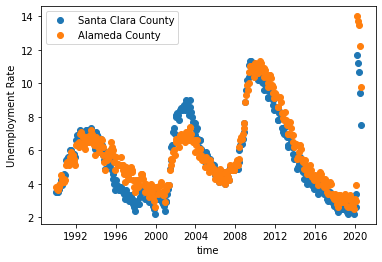

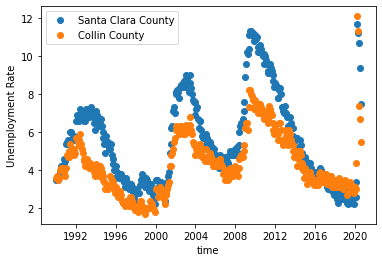

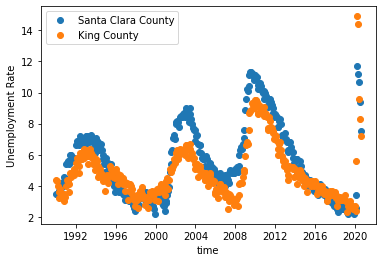

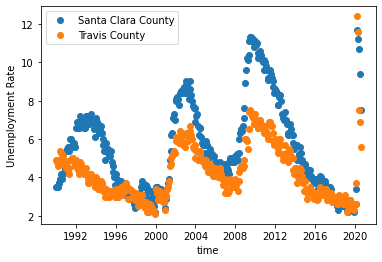

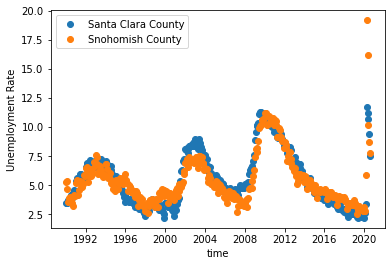

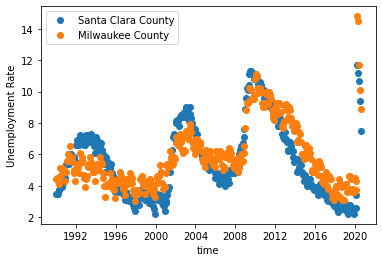

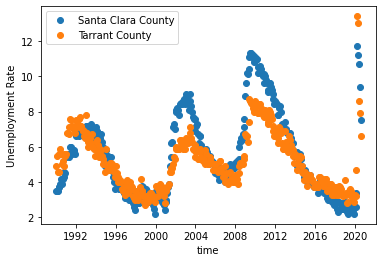

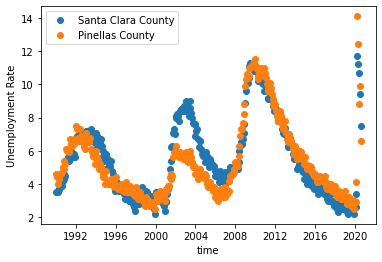

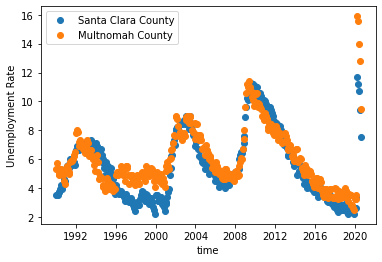

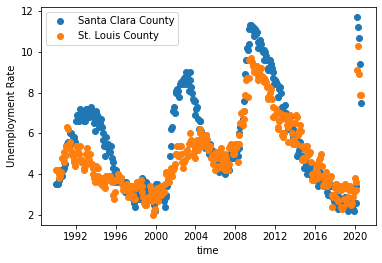

===================================Plotting Median Income time series===================================


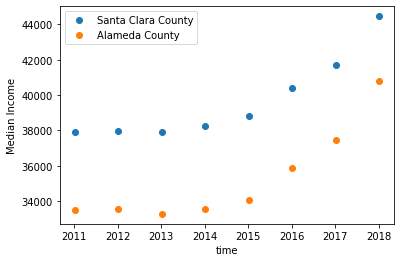

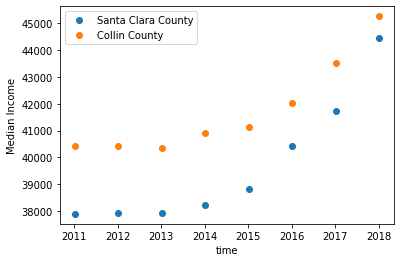

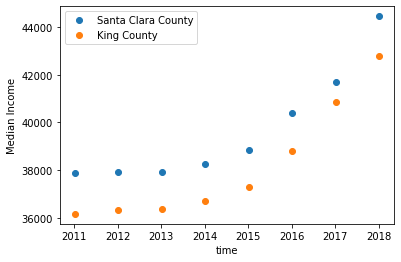

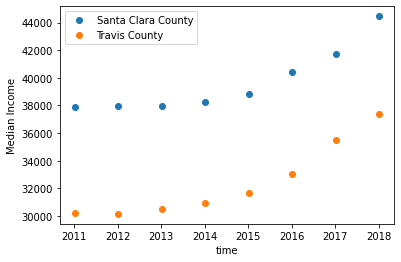

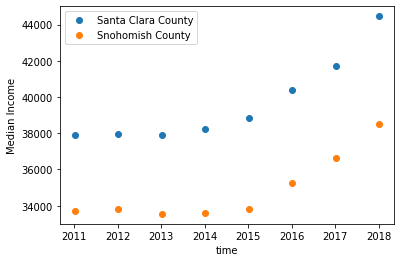

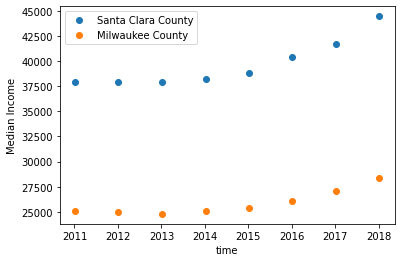

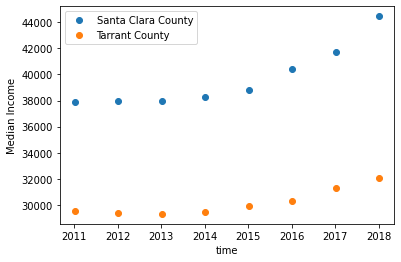

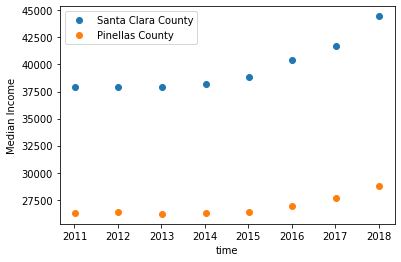

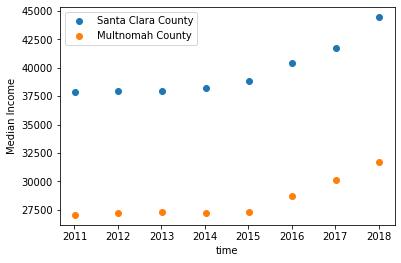

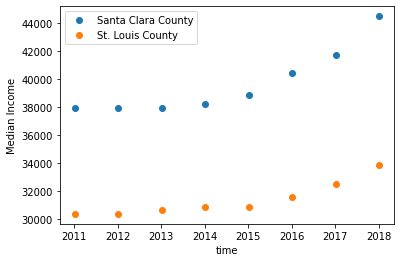

dcid  ... Labor Force Per Capita_date
0   geoId/06085  ...                     2020-08
1   geoId/06001  ...                     2020-08
2   geoId/48085  ...                     2020-08
3   geoId/53033  ...                     2020-08
4   geoId/48453  ...                     2020-08
5   geoId/53061  ...                     2020-08
6   geoId/55079  ...                     2020-08
7   geoId/48439  ...                     2020-08
8   geoId/12103  ...                     2020-08
9   geoId/41051  ...                     2020-08
10  geoId/29189  ...                     2020-08

[11 rows x 5 columns]

In [23]:
statvars = ['UnemploymentRate_Person', 'Median_Income_Person', 'Count_Person_InLaborForce']
per_capita = [False, False, True]
time_series = [True, True, False]
places = dc.get_places_in(['country/USA'], "County")['country/USA']  # look at all counties in US
statvar_display_names = ['Unemployment Rate', 'Median Income', 'Labor Force Per Capita']
time_series_similarity_types = ['pearson', 'pearson', '']  # omit the last element since we are looking at snapshot case for labour force
df = retrieve_compute_visualize(query_dcid, places, statvars, statvar_display_names, per_capita, time_series, time_series_similarity_types, similar, K, quiet=True)
df.head(K + 1)

## Choropleth Visualization

Since we just computed similarity for all counties, we will display a choropleth (heatmap) allowing us to visualize a geographical distribution of counties that are similar to Santa Clara based on the statistical variables and settings we just described. In the below heatmap, the darker the color is, the similar the county is with Santa Clara. This may take a while.

In [24]:
def heatmap_visualization(df, display_topK, k):
    filename = 'us_counties.json'
    with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
        counties_geo = json.load(response)
    df_choro = copy.deepcopy(df)
    df_choro['dcid'] = df_choro['dcid'].apply(lambda x: str(x).replace('geoId/', ''))
    if display_topK:
        df_choro = df_choro[:k + 1]
    fig = px.choropleth(df_choro, geojson=counties_geo, locations='dcid', color=df_choro.index,
                        color_continuous_scale="Viridis",
                        range_color=(0, len(df_choro) - 1),
                        scope="usa",
                        labels={'index': 'rank'}, hover_data={'name'}
                        )
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.show()

In [25]:
display_topK = False
heatmap_visualization(df, display_topK, K)

## What's Next?
You can explore more statistical variable combinations with different settings (snapshot/time series, per capita or different similarity metrics or all of them)! Also don't forget you can change your query place to somewhere else. We provide a few suggestions below just to get you started! Good luck with exploring!

===================================Plotting GDP time series===================================


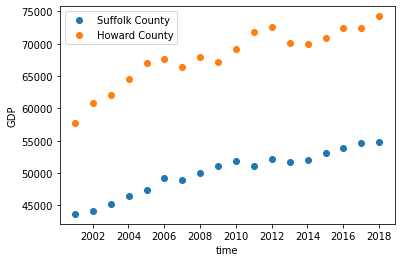

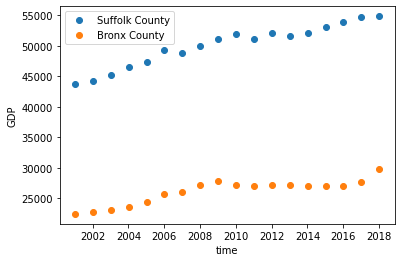

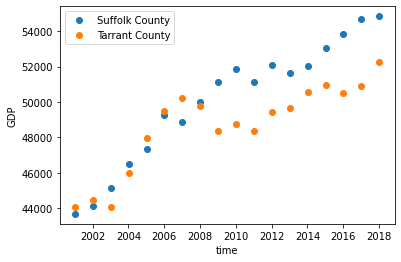

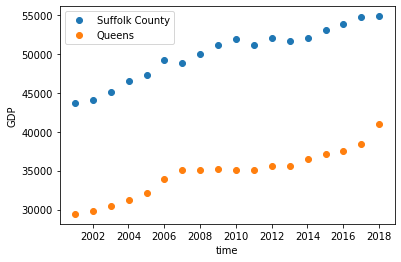

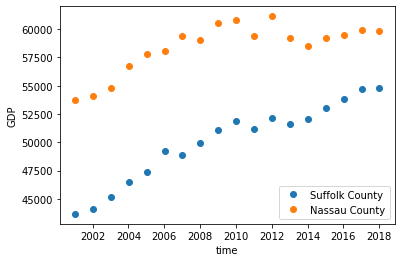

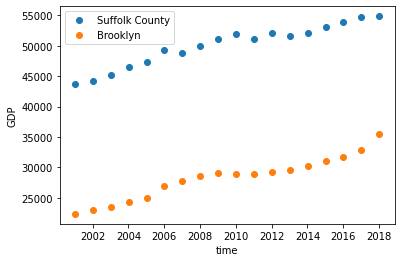

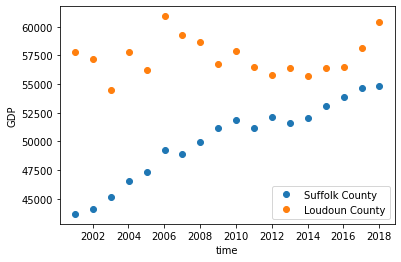

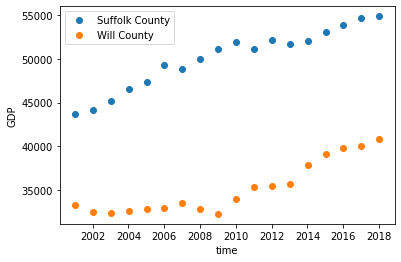

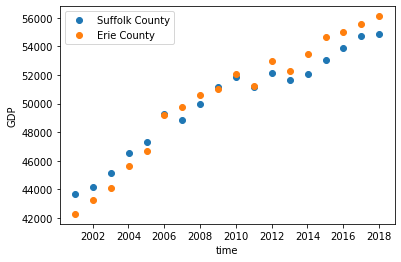

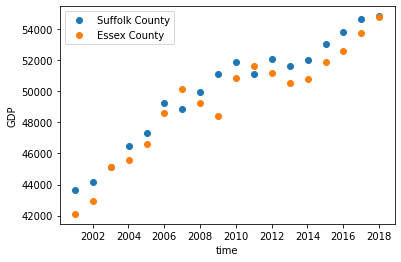

===================================Plotting Number of Establishments time series===================================


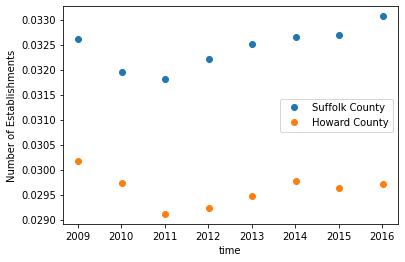

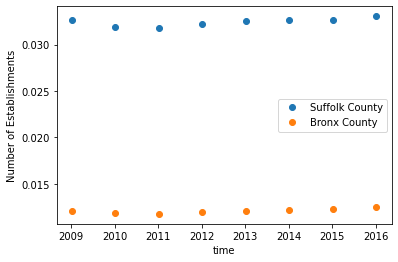

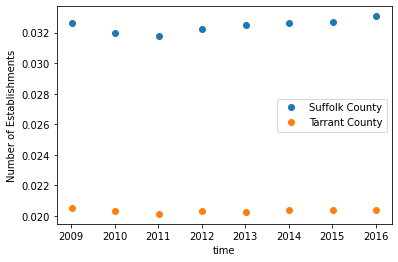

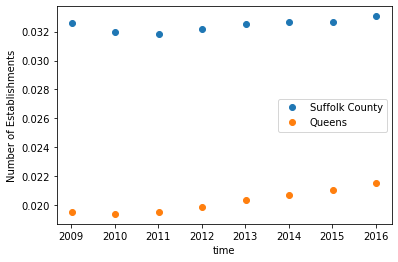

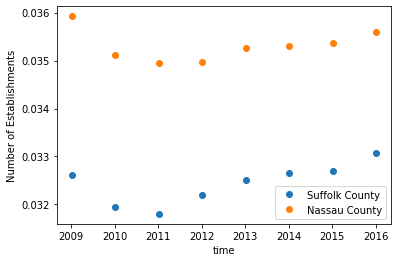

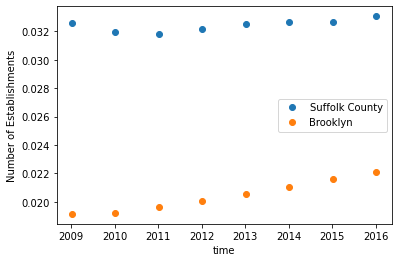

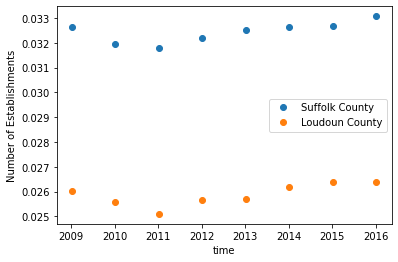

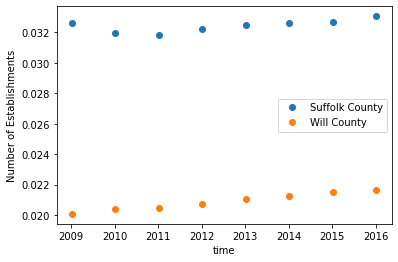

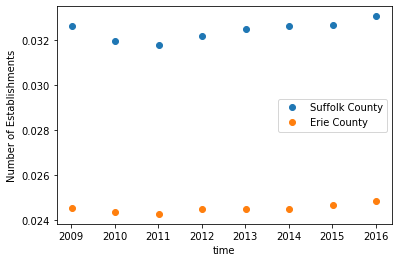

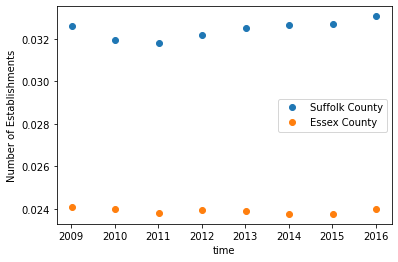

dcid  ... Annual Wages of Establishments_date
0   geoId/36103  ...                                2016
1   geoId/24027  ...                                2016
2   geoId/36005  ...                                2016
3   geoId/48439  ...                                2016
4   geoId/36081  ...                                2016
5   geoId/36059  ...                                2016
6   geoId/36047  ...                                2016
7   geoId/51107  ...                                2016
8   geoId/17197  ...                                2016
9   geoId/36029  ...                                2016
10  geoId/25009  ...                                2016

[11 rows x 5 columns]

In [26]:
query_dcid = 'geoId/36103' # Suffolk county
places = dc.get_places_in(['country/USA'], "County")['country/USA']
statvars = ['Amount_EconomicActivity_GrossDomesticProduction_RealValue', 'Count_Establishment', 'WagesAnnual_Establishment']
statvar_display_names = ['GDP', 'Number of Establishments', 'Annual Wages of Establishments']
per_capita = [True, True, True]
time_series = [True, True, False]
time_series_similarity_types = ['pearson', 'pearson', '']
similar = True
K = 10
df = retrieve_compute_visualize(query_dcid, places, statvars, statvar_display_names, per_capita, time_series, time_series_similarity_types, similar, K, quiet=True)
df.head(K + 1)

In [27]:
query_dcid = 'geoId/15001' # Hawaii county
places = dc.get_places_in(['country/USA'], "County")['country/USA']
statvars = ['CumulativeCount_MedicalConditionIncident_COVID_19_ConfirmedOrProbableCase', 'CumulativeCount_MedicalConditionIncident_COVID_19_PatientDeceased']
statvar_display_names = ['Confirmed or Probable Cases', 'Patients Deceased']
per_capita = [False, False]
time_series = [False, False]
time_series_similarity_types = ['', '']
similar = True
K = 10
df = retrieve_compute_visualize(query_dcid, places, statvars, statvar_display_names, per_capita, time_series, time_series_similarity_types, similar, K, quiet=True)
df.head(K + 1)

dcid               name  ... Patients Deceased  Patients Deceased_date
0   geoId/15001      Hawaii County  ...                43              2020-12-16
1   geoId/18179       Wells County  ...                43              2020-12-16
2   geoId/24047   Worcester County  ...                42              2020-12-16
3   geoId/05005      Baxter County  ...                42              2020-12-16
4   geoId/28163       Yazoo County  ...                44              2020-12-16
5   geoId/01093      Marion County  ...                41              2020-12-16
6   geoId/37123  Montgomery County  ...                44              2020-12-16
7   geoId/28117    Prentiss County  ...                40              2020-12-16
8   geoId/17109   McDonough County  ...                46              2020-12-16
9   geoId/28027     Coahoma County  ...                47              2020-12-16
10  geoId/28057    Itawamba County  ...                44              2020-12-16

[11 rows x 7 columns]